# Modeling Complex Time Series

#### Loading Libraries

In [23]:
# Numerical Computing
import numpy as np
# Data Manipulation
import pandas as pd
# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Warnigs
import warnings

# 
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Statistical Models
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.diagnostic import acorr_ljungbox

# Effective Iteration Progress
from tqdm import tqdm_notebook
# Effective Interators
from itertools import product
# Annotation Type Support
from typing import Union

In [24]:
warnings.filterwarnings('ignore')

In [25]:
%matplotlib inline

#### Simulating an ARMA(p,q) Process

In [26]:
np.random.seed(42)

# Setting Coefficients
ar1 = np.array([1, -0.33])
ma1 = np.array([1, 0.9])

#Appying ARMA
ARMA_1_1 = ArmaProcess(ar1, ma1).generate_sample(nsample=1000)

In [27]:
# Checking for Stationarity
ADF_result = adfuller(ARMA_1_1)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -6.429878682042645
p-value: 1.7078466680101036e-08


##### Checking on ACF

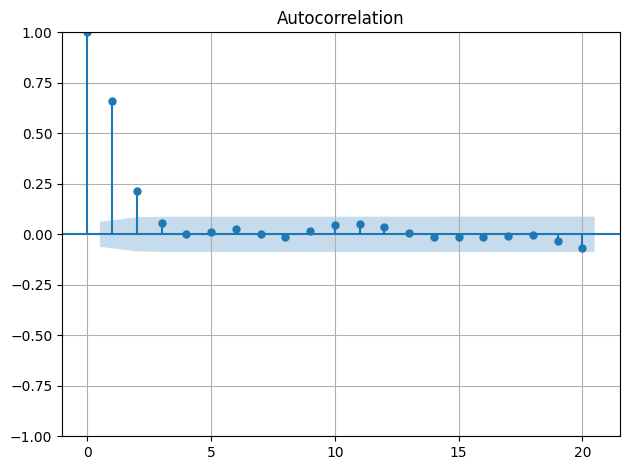

In [28]:
plot_acf(ARMA_1_1, lags=20);

plt.tight_layout()
plt.grid(True)

##### Checking on PACF

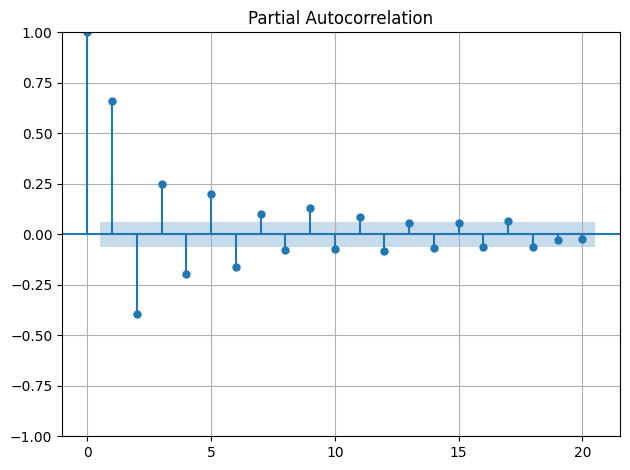

In [29]:
plot_pacf(ARMA_1_1, lags=20);

plt.tight_layout()
plt.grid(True)

#### Selecting a Model Using The AIC

In [30]:
# Possible values
ps = range(0, 4, 1)
qs = range(0, 4, 1)

In [31]:
# Unique combination list
order_list = list(product(ps, qs))
print(order_list)

[(0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 1), (1, 2), (1, 3), (2, 0), (2, 1), (2, 2), (2, 3), (3, 0), (3, 1), (3, 2), (3, 3)]


##### Unique Models ARMA(p,q) Function

In [32]:
def optimize_ARMA(endog: Union[pd.Series, list], order_list: list) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(endog, order=(order[0], 0, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [33]:
# Applying it
result_df = optimize_ARMA(ARMA_1_1, order_list)
result_df

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(1, 1)",2801.407785
1,"(2, 1)",2802.906070
2,"(1, 2)",2802.967762
3,"(0, 3)",2803.666793
4,"(1, 3)",2804.524027
5,"(3, 1)",2804.588567
6,"(2, 2)",2804.822282
7,"(3, 3)",2805.930279
8,"(2, 3)",2806.175380
9,"(3, 2)",2806.894930


##### Qualitative Analysis: Studying the Q-Q Plot

Text(0.5, 1.0, 'Normally Distributed')

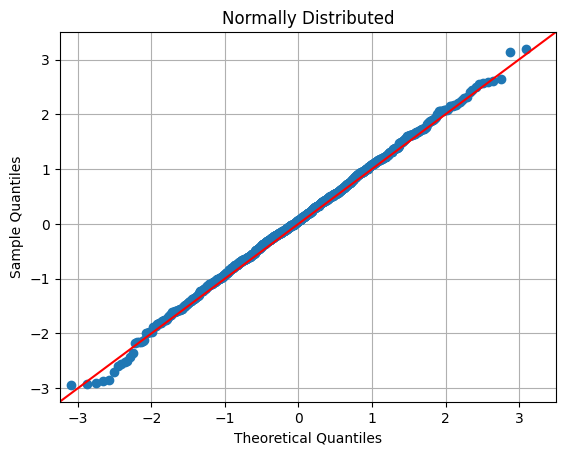

In [34]:
# Normally Distributed
normal = np.random.normal(size=1000)

qqplot(normal, line='45');

plt.grid(True)
plt.title('Normally Distributed')

Text(0.5, 1.0, 'Not Normally Distributed')

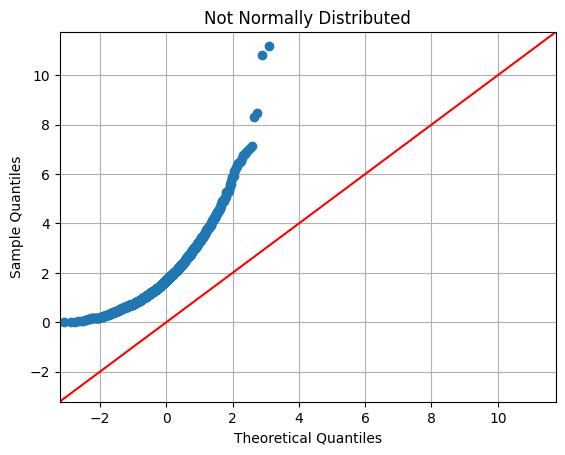

In [35]:
gamma = np.random.default_rng().standard_gamma(shape=2, size=1000)

qqplot(gamma, line='45');

plt.grid(True)
plt.title('Not Normally Distributed')

##### NOTE: Quantitative Analysis is performed based on: Applying Ljung-Box Test

#### Performing Residual Analysis

In [36]:
# Storing & Fitting Model
model = SARIMAX(ARMA_1_1, order=(1,0,1), simple_differencing=False)
model_fit = model.fit(disp=False)
# Storing model residuals
residuals = model_fit.resid

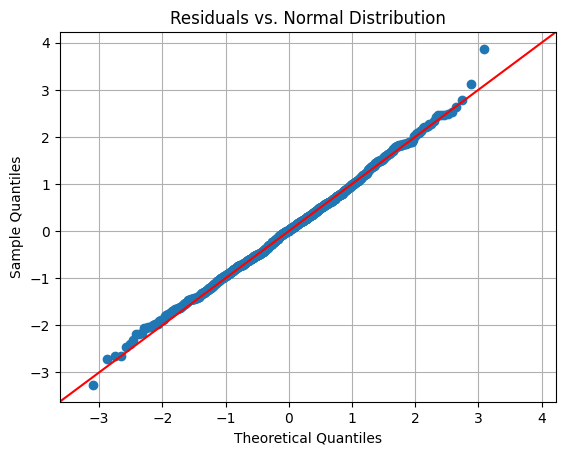

In [37]:
qqplot(residuals, line='45');

plt.title('Residuals vs. Normal Distribution')
plt.grid(True)

##### Diagnostic Method

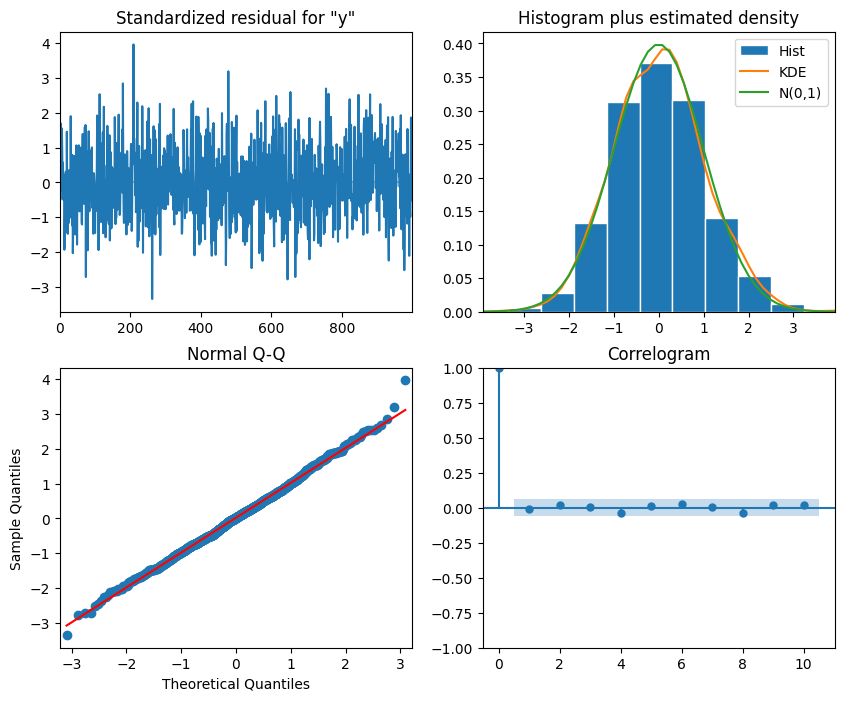

In [38]:
model_fit.plot_diagnostics(figsize=(10, 8));

##### LJung-Box Test

In [40]:
# lbvalue, pvalue = acorr_ljungbox(residuals, np.arange(1, 11, 1))

# print(pvalue)

In [42]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Running the Ljung-Box test on the residuals
results = acorr_ljungbox(residuals, lags=np.arange(1, 11, 1))

# Accessing the p-values from the results dictionary
pvalues = results['lb_pvalue']

print(pvalues)

1     0.860897
2     0.767966
3     0.909817
4     0.721089
5     0.810385
6     0.821750
7     0.894063
8     0.817501
9     0.852419
10    0.874093
Name: lb_pvalue, dtype: float64


#### Applying The General Modeling Procedure

In [44]:
df = pd.read_csv('/Users/isisromero/desktop/time_series/data/bandwidth.csv')
df.head()

,hourly_bandwidth
0,1000.496714
1,1000.969408
2,1002.046019
3,1004.702118
4,1007.447816


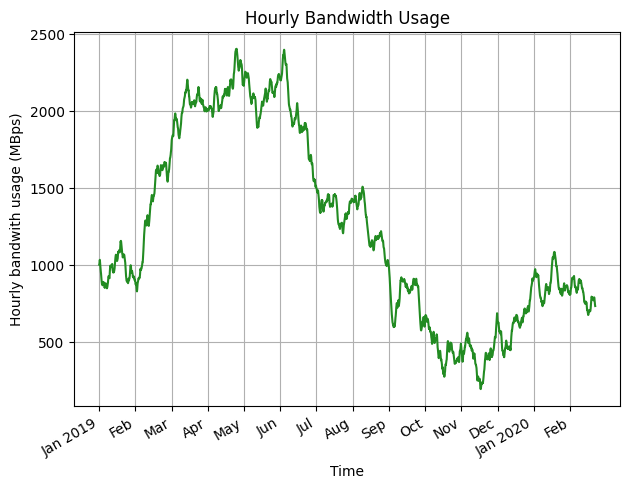

In [47]:
fig, ax = plt.subplots()

ax.plot(df['hourly_bandwidth'], color='forestgreen')
ax.set_xlabel('Time')
ax.set_ylabel('Hourly bandwith usage (MBps)')

plt.xticks(
    np.arange(0, 10000, 730), 
    ['Jan 2019', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan 2020', 'Feb'])

fig.autofmt_xdate()
plt.tight_layout()
plt.title('Hourly Bandwidth Usage')
plt.grid(True)

In [48]:
# Checking on stationarity onf long-term trend
ADF_result = adfuller(df['hourly_bandwidth'])

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -0.8714653199453133
p-value: 0.7972240255014424


In [49]:
# Applying transformation to data
bandwidth_diff = np.diff(df.hourly_bandwidth, n=1)

In [50]:
# Re-applying ADF Test
ADF_result = adfuller(bandwidth_diff)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -20.69485386378899
p-value: 0.0


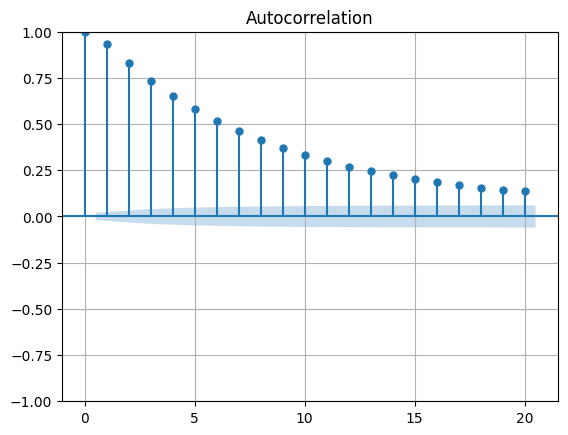

In [52]:
# Checking on ACF
plot_acf(bandwidth_diff, lags=20);
plt.grid(True)

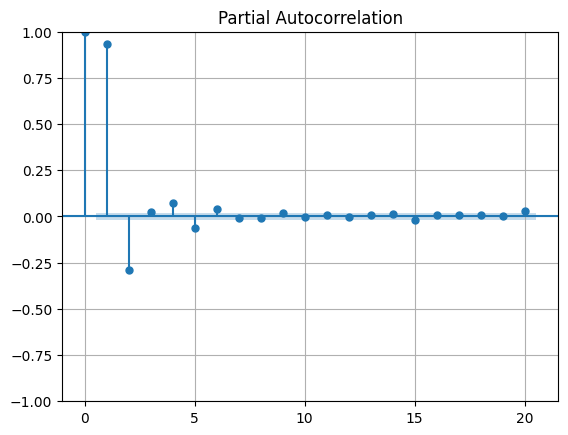

In [53]:
# Checking on PACF
plot_pacf(bandwidth_diff, lags=20);
plt.grid(True)

##### Splitting Data Procedure

In [54]:
df_diff = pd.DataFrame({'bandwidth_diff': bandwidth_diff})

train = df_diff[:-168]
test = df_diff[-168:]

print(len(train))
print(len(test))

9831
168


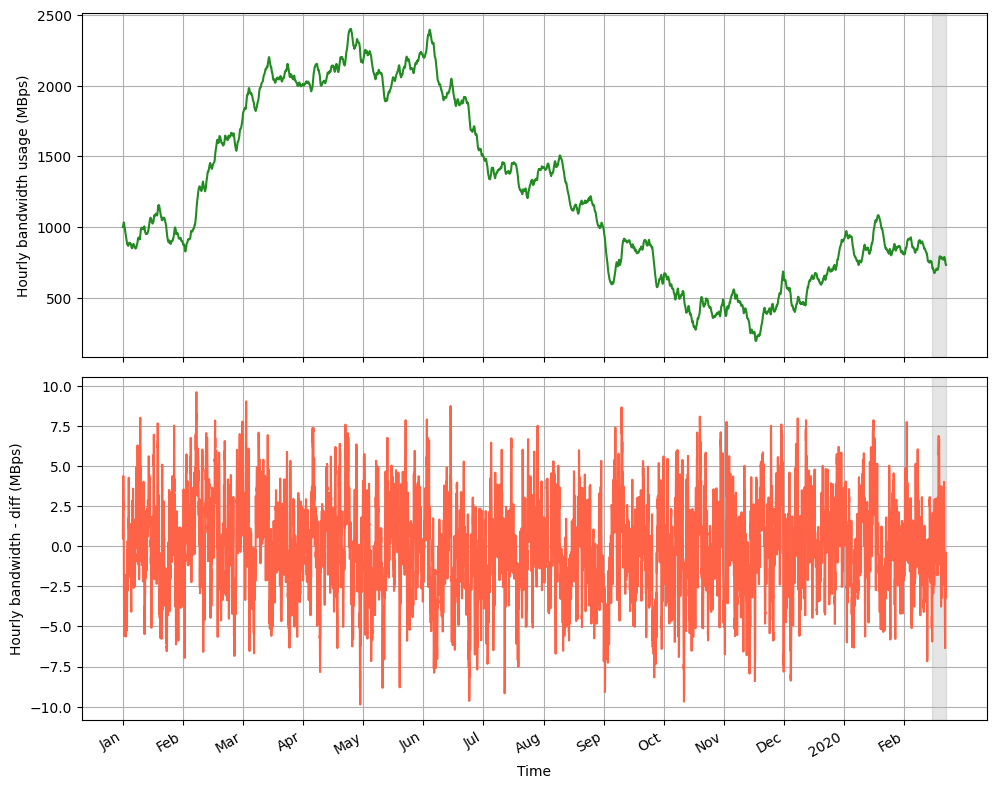

In [59]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 8))

ax1.plot(df['hourly_bandwidth'], color='forestgreen')
ax1.set_xlabel('Time')
ax1.set_ylabel('Hourly bandwidth usage (MBps)')
ax1.axvspan(9831, 10000, color='#808080', alpha=0.2)
ax1.grid(True)

ax2.plot(df_diff['bandwidth_diff'], color='tomato')
ax2.set_xlabel('Time')
ax2.set_ylabel('Hourly bandwidth - diff (MBps)')
ax2.axvspan(9830, 9999, color='#808080', alpha=0.2)
ax2.grid(True)

plt.xticks(
    np.arange(0, 10000, 730), 
    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '2020', 'Feb'])

fig.autofmt_xdate()
plt.tight_layout()

##### Fitting Unique ARMA(p,q) Model Function

In [60]:
def optimize_ARMA(endog: Union[pd.Series, list], order_list: list) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(endog, order=(order[0], 0, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [61]:
# Setting (p order,)
ps = range(0, 4, 1)
# Setting (,q order)
qs = range(0, 4, 1)

order_list = list(product(ps, qs))

In [62]:
result_df = optimize_ARMA(train['bandwidth_diff'], order_list)
result_df

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(3, 2)",27991.063879
1,"(2, 3)",27991.287509
2,"(2, 2)",27991.603598
3,"(3, 3)",27993.416924
4,"(1, 3)",28003.349550
5,"(1, 2)",28051.351401
6,"(3, 1)",28071.155497
7,"(3, 0)",28095.618186
8,"(2, 1)",28097.250766
9,"(2, 0)",28098.407664


In [63]:
model = SARIMAX(train['bandwidth_diff'], order=(2,0,2), simple_differencing=False)
model_fit = model.fit(disp=False)
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:         bandwidth_diff   No. Observations:                 9831
Model:               SARIMAX(2, 0, 2)   Log Likelihood              -13990.802
Date:                Mon, 26 Feb 2024   AIC                          27991.604
Time:                        10:03:01   BIC                          28027.570
Sample:                             0   HQIC                         28003.788
                               - 9831                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3486      0.052      6.765      0.000       0.248       0.450
ar.L2          0.4743      0.047     10.000      0.000       0.381       0.567
ma.L1          0.8667      0.050     17.249      0.0

##### Plotting Diagnose

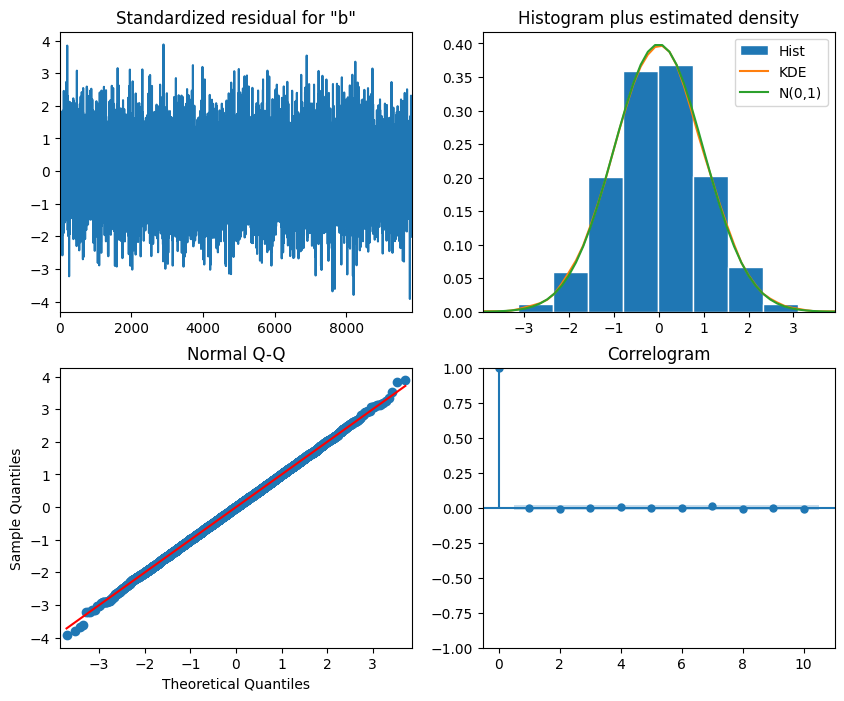

In [64]:
model_fit.plot_diagnostics(figsize=(10, 8));

##### Re-running The LJung-Box Test

In [65]:
# Running the Ljung-Box test on the residuals

residuals = model_fit.resid 

results = acorr_ljungbox(residuals, lags=np.arange(1, 11, 1))

# Accessing the p-values from the results dictionary
pvalues = results['lb_pvalue']

print(pvalues)

1     0.837257
2     0.811247
3     0.914416
4     0.931545
5     0.973678
6     0.981019
7     0.952607
8     0.919067
9     0.953615
10    0.964015
Name: lb_pvalue, dtype: float64


#### Forecasting Bandwidth Usage

##### Setting Horizon Rolling Forecast Function

In [66]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    end_idx = train_len
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
            
        return pred_mean

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'ARMA':
        pred_ARMA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(2,0,2))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_ARMA.extend(oos_pred)
            
        return pred_ARMA

#### Evaluating All Forecasting Models

In [68]:
pred_df = test.copy()

TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2

pred_mean = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_ARMA = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'ARMA')

test.loc[:, 'pred_mean'] = pred_mean
test.loc[:, 'pred_last_value'] = pred_last_value
test.loc[:, 'pred_ARMA'] = pred_ARMA

pred_df.head()

,bandwidth_diff,pred_mean,pred_last_value,pred_ARMA
9831,-5.943995,-0.028214,-5.791207,-5.460661
9832,-5.865194,-0.028214,-5.791207,-4.890626
9833,-3.197066,-0.029410,-5.865194,-5.335905
9834,-1.090197,-0.029410,-5.865194,-4.751731
9835,0.665291,-0.029840,-1.090197,-0.375596


##### Checking outcomes

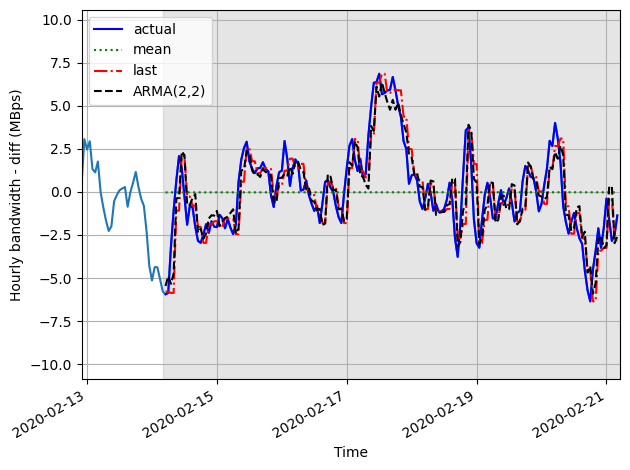

In [69]:
fig, ax = plt.subplots()

ax.plot(df_diff['bandwidth_diff'])
ax.plot(test['bandwidth_diff'], 'b-', label='actual')
ax.plot(test['pred_mean'], 'g:', label='mean')
ax.plot(test['pred_last_value'], 'r-.', label='last')
ax.plot(test['pred_ARMA'], 'k--', label='ARMA(2,2)')
ax.grid(True)

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Hourly bandwidth - diff (MBps)')

ax.axvspan(9830, 9999, color='#808080', alpha=0.2)

ax.set_xlim(9800, 9999)

plt.xticks(
    [9802, 9850, 9898, 9946, 9994],
    ['2020-02-13', '2020-02-15', '2020-02-17', '2020-02-19', '2020-02-21'])

fig.autofmt_xdate()
plt.tight_layout()

##### Mean Squared Error Evaluation

In [70]:
mse_mean = mean_squared_error(test['bandwidth_diff'], test['pred_mean'])
mse_last = mean_squared_error(test['bandwidth_diff'], test['pred_last_value'])
mse_ARMA = mean_squared_error(test['bandwidth_diff'], test['pred_ARMA'])

print(mse_mean, mse_last, mse_ARMA)

6.306526957989325 2.2297582947733656 1.7690462113807348


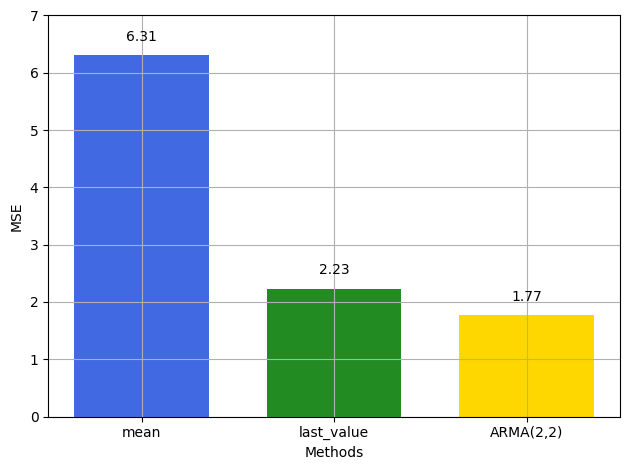

In [73]:
fig, ax = plt.subplots()

x = ['mean', 'last_value', 'ARMA(2,2)']
y = [mse_mean, mse_last, mse_ARMA] 

ax.bar(x, y, width=0.7, color=['royalblue', 'forestgreen', 'gold'])
ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
ax.set_ylim(0, 7)
ax.grid(True)

for index, value in enumerate(y):
    plt.text(x=index, y=value+0.25, s=str(round(value, 2)), ha='center')

plt.tight_layout()

#### Reversing Procedure

In [74]:
df['pred_bandwidth'] = pd.Series()
df['pred_bandwidth'][9832:] = df['hourly_bandwidth'].iloc[9832] + test['pred_ARMA'].cumsum()

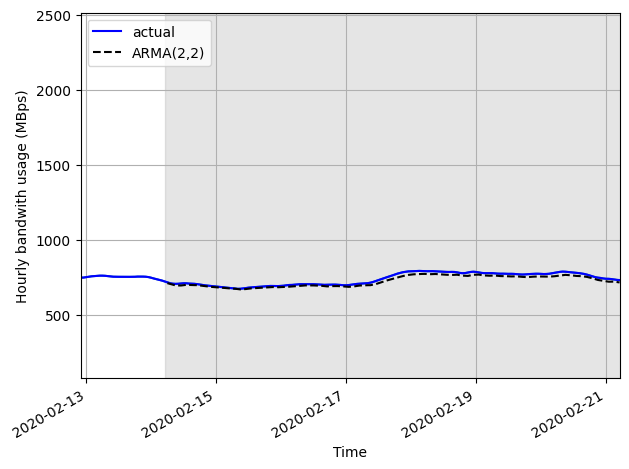

In [75]:
fig, ax = plt.subplots()

ax.plot(df['hourly_bandwidth'])
ax.plot(df['hourly_bandwidth'], 'b-', label='actual')
ax.plot(df['pred_bandwidth'], 'k--', label='ARMA(2,2)')
ax.grid(True)

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Hourly bandwith usage (MBps)')

ax.axvspan(9831, 10000, color='#808080', alpha=0.2)

ax.set_xlim(9800, 9999)

plt.xticks(
    [9802, 9850, 9898, 9946, 9994],
    ['2020-02-13', '2020-02-15', '2020-02-17', '2020-02-19', '2020-02-21'])

fig.autofmt_xdate()
plt.tight_layout()

##### ARMA Model Mean Absolute Error Evaluation

In [77]:
mae_ARMA_undiff = mean_absolute_error(df['hourly_bandwidth'][9832:], df['pred_bandwidth'][9832:])

print(mae_ARMA_undiff)

14.000362775548533
